In [1]:
!pip3 install flair

     |████████████████████████████████| 143kB 3.6MB/s eta 0:00:01
  Created wheel for sqlitedict: filename=sqlitedict-1.6.0-cp36-none-any.whl size=14689 sha256=e6ef9000bd6772c7bc4016f7158475d76a234b4de38d40660a7c9dab9f3eaac0
  Stored in directory: /tmp/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23257 sha256=10a2c55c61d2155fcf307614d861ea3d36b8794a802f2141789a4d2b9434c916
  Stored in directory: /tmp/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
Successfully built sqlitedict segtok
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

True

> ## Create a Corpus

### 1) Load from simple CSV file

In [3]:
from flair.datasets import CSVClassificationCorpus

ImportError: cannot import name 'CSVClassificationCorpus'

Great development..

### 2) FastText Format

In [4]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [5]:
FILE_PATH = "../input/bbc-text.csv"
DATASET_FOLDER_PATH = "splitted_data"
# DATASET_FOLDER_PATH = os.path.join("splitted_data", FILE_PATH.split(".")[0].split("/")[1])

column_name = {
    "text": "text",
    "label": "category"
}

# file format
__label__<label_1> <text>
__label__<label_1> __label__<label_2> <text>

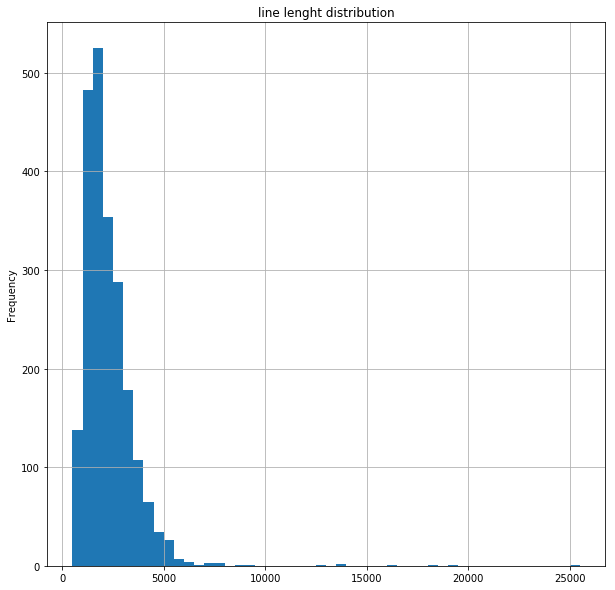

In [6]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

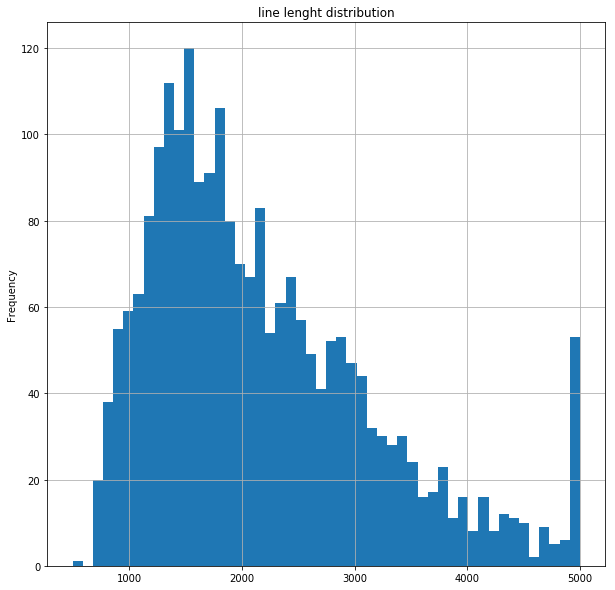

In [7]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = clear_text(data_df["text"])
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:5000])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [8]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [9]:
corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-11 17:52:39,259 Reading data from splitted_data
2019-08-11 17:52:39,269 Train: splitted_data/train.csv
2019-08-11 17:52:39,271 Dev: splitted_data/dev.csv
2019-08-11 17:52:39,272 Test: splitted_data/test.csv


Each line in a corpus is converted to a Sentence object annotated with the labels.

## Check distribution

In [10]:
train_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "train.csv"), names=["label", "text"], delimiter="\t")
train_df.label.value_counts()

__label__sport            415
__label__business         403
__label__politics         335
__label__tech             328
__label__entertainment    299
Name: label, dtype: int64

In [11]:
val_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "dev.csv"), names=["label", "text"], delimiter="\t")
val_df.label.value_counts()

__label__business         57
__label__sport            45
__label__politics         44
__label__entertainment    39
__label__tech             37
Name: label, dtype: int64

In [12]:
test_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "test.csv"), names=["label", "text"], delimiter="\t")
test_df.label.value_counts()

__label__sport            51
__label__business         50
__label__entertainment    48
__label__politics         38
__label__tech             36
Name: label, dtype: int64

## Training a Model

## ELMO

In [13]:
from flair.embeddings import ELMoEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
from flair.visual.training_curves import Plotter

In [14]:
MODEL_FOLDER_PATH = "model/ELMO"
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

In [15]:
params_train = {
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 20,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

word_embeddings = [ELMoEmbeddings(), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
100%|██████████| 374434792/374434792 [00:24<00:00, 15469716.72B/s]


2019-08-11 17:53:51,008 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpit9wr4q2


100%|██████████| 19689779/19689779 [00:00<00:00, 38253859.70B/s]

2019-08-11 17:53:51,683 copying /tmp/tmpit9wr4q2 to cache at /tmp/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt
2019-08-11 17:53:51,719 removing temp file /tmp/tmpit9wr4q2


2019-08-11 17:53:51,884 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp8et5ixrr


100%|██████████| 19689779/19689779 [00:00<00:00, 38519049.34B/s]

2019-08-11 17:53:52,539 copying /tmp/tmp8et5ixrr to cache at /tmp/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt
2019-08-11 17:53:52,571 removing temp file /tmp/tmp8et5ixrr


2019-08-11 17:54:13,365 {'politics', 'sport', 'business', 'tech', 'entertainment'}


In [16]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

2019-08-11 18:01:17,149 ----------------------------------------------------------------------------------------------------
2019-08-11 18:01:17,153 learning rate finder finished - plot model/ELMO/learning_rate.tsv
2019-08-11 18:01:17,154 ----------------------------------------------------------------------------------------------------


<img src="model/ELMO/learning_rate.png" height=1000, width=1000>

In [ ]:
trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"], evaluation_metric=params_train["evaluation_metric"])

2019-08-11 18:02:04,152 ----------------------------------------------------------------------------------------------------
2019-08-11 18:02:04,153 Evaluation method: MICRO_ACCURACY
2019-08-11 18:02:04,416 ----------------------------------------------------------------------------------------------------
2019-08-11 18:02:20,715 epoch 1 - iter 0/56 - loss 1.66563940
2019-08-11 18:02:53,594 epoch 1 - iter 5/56 - loss 1.86702039
2019-08-11 18:03:30,495 epoch 1 - iter 10/56 - loss 1.65991586
2019-08-11 18:04:03,430 epoch 1 - iter 15/56 - loss 1.59623009
2019-08-11 18:04:40,887 epoch 1 - iter 20/56 - loss 1.47140576
2019-08-11 18:05:15,659 epoch 1 - iter 25/56 - loss 1.31496103
2019-08-11 18:05:51,755 epoch 1 - iter 30/56 - loss 1.20269874
2019-08-11 18:06:28,388 epoch 1 - iter 35/56 - loss 1.09714871
2019-08-11 18:07:04,119 epoch 1 - iter 40/56 - loss 1.03887122
2019-08-11 18:07:38,228 epoch 1 - iter 45/56 - loss 0.99638605
2019-08-11 18:08:12,084 epoch 1 - iter 50/56 - loss 0.96126731
2

2019-08-11 19:00:00,733 epoch 7 - iter 45/56 - loss 0.06217593
2019-08-11 19:00:37,357 epoch 7 - iter 50/56 - loss 0.05917353
2019-08-11 19:01:12,192 epoch 7 - iter 55/56 - loss 0.05950662
2019-08-11 19:01:12,747 ----------------------------------------------------------------------------------------------------
2019-08-11 19:01:12,748 EPOCH 7 done: loss 0.0595 - lr 0.1000 - bad epochs 3
2019-08-11 19:02:08,932 DEV : loss 0.3773069977760315 - score 0.9054
2019-08-11 19:03:04,793 TEST : loss 0.2623589038848877 - score 0.9283
Epoch     6: reducing learning rate of group 0 to 5.0000e-02.
2019-08-11 19:03:04,797 ----------------------------------------------------------------------------------------------------
2019-08-11 19:03:23,472 epoch 8 - iter 0/56 - loss 0.01833333
2019-08-11 19:04:01,556 epoch 8 - iter 5/56 - loss 0.03007800
2019-08-11 19:04:39,950 epoch 8 - iter 10/56 - loss 0.04076599
2019-08-11 19:05:17,046 epoch 8 - iter 15/56 - loss 0.03445228
2019-08-11 19:05:52,393 epoch 8 -

2019-08-11 19:56:54,129 epoch 14 - iter 5/56 - loss 0.01719447
2019-08-11 19:57:31,653 epoch 14 - iter 10/56 - loss 0.01179693
2019-08-11 19:58:09,514 epoch 14 - iter 15/56 - loss 0.01076735
2019-08-11 19:58:47,695 epoch 14 - iter 20/56 - loss 0.01048471
2019-08-11 19:59:23,678 epoch 14 - iter 25/56 - loss 0.00955294
2019-08-11 19:59:59,399 epoch 14 - iter 30/56 - loss 0.00923423
2019-08-11 20:00:38,152 epoch 14 - iter 35/56 - loss 0.00990424
2019-08-11 20:01:09,678 epoch 14 - iter 40/56 - loss 0.00965503
2019-08-11 20:01:47,194 epoch 14 - iter 45/56 - loss 0.00959302
2019-08-11 20:02:20,082 epoch 14 - iter 50/56 - loss 0.00916652
2019-08-11 20:02:54,082 epoch 14 - iter 55/56 - loss 0.00940175
2019-08-11 20:02:54,521 ----------------------------------------------------------------------------------------------------
2019-08-11 20:02:54,523 EPOCH 14 done: loss 0.0094 - lr 0.0250 - bad epochs 1
2019-08-11 20:03:50,287 DEV : loss 0.3189544677734375 - score 0.9369
2019-08-11 20:04:45,698 T

2019-08-11 20:55:57,360 EPOCH 20 done: loss 0.0061 - lr 0.0125 - bad epochs 3
2019-08-11 20:56:51,721 DEV : loss 0.3310847282409668 - score 0.9369
2019-08-11 20:57:47,560 TEST : loss 0.2072819620370865 - score 0.9596


## Plot training curves

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(MODEL_FOLDER_PATH, 'loss.tsv'))
plotter.plot_weights(os.path.join(MODEL_FOLDER_PATH, 'weights.txt'))